In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/rwalk/gsdmm

fatal: destination path 'gsdmm' already exists and is not an empty directory.


In [3]:
#imports
import os
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim.models.coherencemodel import CoherenceModel

from gsdmm.gsdmm import MovieGroupProcess

from src.text_preprocessor import TextPreprocessor
from src.embeddor import Embeddor
from src.meta_data_preprocessor import MetaDataPreprocessor

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_palette("husl")

/opt/anaconda3/lib/python3.8/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, defaultdict, Iterable
/opt/anaconda3/lib/python3.8/site-packages/nltk/decorators.py:67: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` objec

In [4]:
DATA_FOLDER = "../data/inputs"
DATA1 = "seatguru_python_scraping.csv"
DATA2 = "skytrax_scraping_2.csv"

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
df1 = pd.read_csv(os.path.join(DATA_FOLDER, DATA1), index_col=0)
df2 = pd.read_csv(os.path.join(DATA_FOLDER, DATA2), index_col=0)
concat_df = pd.concat([df1, df2])
concat_df.reset_index(inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df1.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,body,airline,aircraft
0,2019/12/29,From Istabul to Athens. Seat 3C doesnt have an...,aegean-airlines,airbus_a319-100
0,2018/06/09,I traveled Athens-Zurich with Aegean Airlines ...,aegean-airlines,airbus_a320-200
1,2018/05/25,very tiny leg room as I am quite tall. flight ...,aegean-airlines,airbus_a320-200
2,2018/04/19,Exit row 12F was nice for the 2.5 hour ZRH-ATH...,aegean-airlines,airbus_a320-200
3,2017/07/22,It is a wonderful seat at no additional cost (...,aegean-airlines,airbus_a320-200


In [7]:
df2.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,number_of_reviews,date,rating,header,body,aircraft,cabin,airline
0,Netherlands,NaN,2019-11-11,9.0,"""pretty decent airline""",✅ Trip Verified | Moroni to Moheli. Turned ou...,NaN,NaN,ab-aviation
1,United Kingdom,26 reviews,2019-06-25,1.0,"""Not a good airline""",✅ Trip Verified | Moroni to Anjouan. It is a v...,E120,NaN,ab-aviation
2,United Kingdom,26 reviews,2019-06-25,1.0,"""flight was fortunately short""",✅ Trip Verified | Anjouan to Dzaoudzi. A very...,Embraer E120,NaN,ab-aviation
0,Serbia,NaN,2019-09-28,1.0,"""I will never fly again with Adria""",Not Verified | Please do a favor yourself and...,NaN,NaN,adria-airways
1,Netherlands,NaN,2019-09-24,1.0,"""it ruined our last days of holidays""",✅ Trip Verified | Do not book a flight with th...,NaN,NaN,adria-airways


# EDA

## Balance

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


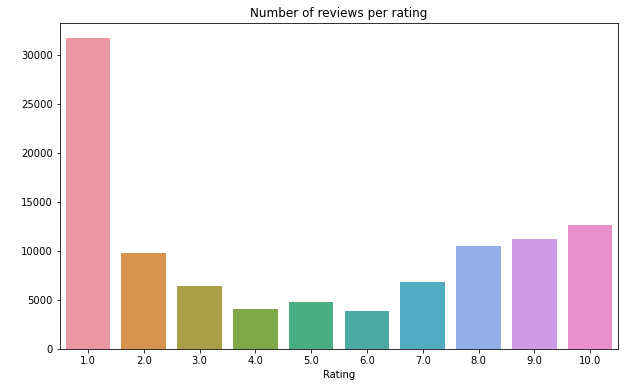

In [8]:
sns.countplot(x='rating', data=df2)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

In [9]:
# def bin(rating):
#     if rating <= 3:
#         return "Bad"
#     elif rating > 3 and rating < 8:
#         return "Medium"
#     else:
#         return "Good"

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# df2['bin'] = df2['rating'].apply(bin)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# sns.countplot(x='bin', data=df2)
# plt.title('Number of reviews per bin')
# plt.xlabel('Rating')
# plt.ylabel(' ')
# plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Adding meta-data

In [13]:
meta_data_preprocessor = MetaDataPreprocessor()
df_with_metadata = meta_data_preprocessor.preprocess(concat_df)
df_with_metadata.to_pickle(os.path.join("..", "data", "preprocessed", "reviews_metadata.pickle"))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[D 220201 12:06:35 meta_data_preprocessor:112] Extracting airplane data
[D 220201 12:06:37 meta_data_preprocessor:114] Extracting cities and countries
[D 220201 12:06:37 meta_data_preprocessor:91] Parsing review 0
[D 220201 12:07:12 meta_data_preprocessor:91] Parsing review 10000
[D 220201 12:07:41 meta_data_preprocessor:91] Parsing review 20000
[D 220201 12:08:07 meta_data_preprocessor:91] Parsing review 30000
[D 220201 12:08:32 meta_data_preprocessor:91] Parsing review 40000
[D 220201 12:08:57 meta_data_preprocessor:91] Parsing review 50000
[D 220201 12:09:25 meta_data_preprocessor:91] Parsing review 60000
[D 220201 12:09:50 meta_da

In [14]:
df_with_metadata.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,date,body,airline,aircraft,country,number_of_reviews,rating,header,cabin,trip_type,size,bin,cities,countries
0,0,2019/12/29,From Istabul to Athens. Seat 3C doesnt have an...,aegean-airlines,airbus_a319-100,NaN,NaN,NaN,NaN,NaN,short_haul,small,2,[Athens],[Greece]
1,0,2018/06/09,I traveled Athens-Zurich with Aegean Airlines ...,aegean-airlines,airbus_a320-200,NaN,NaN,NaN,NaN,NaN,short_haul,medium,2,[Athens],[Greece]
2,1,2018/05/25,very tiny leg room as I am quite tall. flight ...,aegean-airlines,airbus_a320-200,NaN,NaN,NaN,NaN,NaN,short_haul,medium,2,[],[]
3,2,2018/04/19,Exit row 12F was nice for the 2.5 hour ZRH-ATH...,aegean-airlines,airbus_a320-200,NaN,NaN,NaN,NaN,NaN,short_haul,medium,2,[],[]
4,3,2017/07/22,It is a wonderful seat at no additional cost (...,aegean-airlines,airbus_a320-200,NaN,NaN,NaN,NaN,NaN,short_haul,medium,2,[],[]


## Time series annalysis

In [ ]:
df3 = df2.copy()
df3.date = pd.to_datetime(df3.date)
df3 = df3.loc[df3.airline == "american-airlines"]
df3['month'] = df3.date.dt.month
df3['year'] = df3.date.dt.year
rat_by_month = df3.dropna(subset=["rating"]).groupby(["month", "year"]).agg({'rating':'mean'}).sort_index(level=[1, 0])
rat_by_month.index = rat_by_month.index.get_level_values(0).astype(str) + '-' + rat_by_month.index.get_level_values(1).astype(str)
#rat_by_month['date'] = rat_by_month.month.astype(str) + '-' + rat_by_month.year.astype(str)
rat_by_month.plot()

In [ ]:
df4 = df2.copy()
df4.date = pd.to_datetime(df4.date)
df4 = df4.loc[df4.airline == "american-airlines"]
df4['month'] = df4.date.dt.month
df4['year'] = df4.date.dt.year
rat_by_month = df4.dropna(subset=["rating"]).groupby(["month", "year"]).agg({'rating':'count'}).sort_index(level=[1, 0])
rat_by_month.index = rat_by_month.index.get_level_values(0).astype(str) + '-' + rat_by_month.index.get_level_values(1).astype(str)
#rat_by_month['date'] = rat_by_month.month.astype(str) + '-' + rat_by_month.year.astype(str)
rat_by_month.plot()

# TF-IDF

In [ ]:
df_good = df2.loc[df2.bin == "Good"]
preprocessor = TextPreprocessor(df_good, column_to_clean='body')
preprocessor.transform(n_grams=False, remove_stopwords=True)
corpus_good = preprocessor.corpus

df_bad = df2.loc[df2.bin == "Bad"]
preprocessor = TextPreprocessor(df_bad, column_to_clean='body')
preprocessor.transform(n_grams=False, remove_stopwords=True)
corpus_bad = preprocessor.corpus

In [ ]:
tf_idf_matrix = tf_idf(corpus_good, wordcloud=True, rating="Good")

In [ ]:
tf_idf_matrix = tf_idf(corpus_bad, wordcloud=True, rating="Bad")

# Embedding

In [ ]:
df2_small = df2.copy().iloc[:5000, :]
preprocessor = TextPreprocessor(df2_small, column_to_clean='body')
preprocessor.transform(n_grams=False, remove_stopwords=True)
corpus = preprocessor.corpus

In [ ]:
embeddor = Embeddor(corpus=corpus)
embeddor.transform(vec_method="word2vec", how="PCA", n=3)
lsi = embeddor.description_embedding
word2vec_model = embeddor.model
lsi['corpus'] = corpus
lsi['rating'] = df2_small['rating']
lsi.head()

In [ ]:
for i in range(3):
    rat_list = []
    lsi[f'Dimension_{i+1}'] = np.abs(lsi[f'Dimension_{i+1}'])
    top_words = lsi.sort_values(f'Dimension_{i+1}', ascending=False).index[:5]
    print((f"Top reviews for topic {i} are : "))
    print(lsi.corpus.apply(lambda x: x[2:]).iloc[top_words])
    print(f"Average rating for topic {i} are : ")
    ratings = df2_small.rating.tolist()
    for ind in list(top_words):
        rat_list.append(ratings[ind])
    print(np.mean(rat_list))
    print()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

colors = ['red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green']

for val in lsi['rating'].dropna().astype(int).unique():
    topic_1 = np.abs(lsi[lsi['rating']==val]['Dimension_1'].values)
    topic_2 = np.abs(lsi[lsi['rating']==val]['Dimension_3'].values)
    color = colors[val-1]
    ax.scatter(topic_1, topic_2, alpha=0.7, label=val, color=color)
    
ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth=0.5)
ax.axhline(linewidth=0.5)
ax.legend()

# LDA

In [ ]:
df2_small["corpus"] = corpus

In [ ]:
#Dictionary
tokens = df2_small.corpus
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
corpus_lda = [dictionary.doc2bow(tok) for tok in tokens]

In [ ]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus_lda,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           alpha=0.1,
                                           eta=0.1,
                                           per_word_topics=True)

In [ ]:
for i, topic in ldaModel.show_topics(formatted=True, num_topics=10, num_words=20):
    print(str(i)+": "+ topic+"\n")

In [ ]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, texts=tokens ,coherence="c_v")
cm.get_coherence()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, corpus_lda, dictionary)
vis

# GSDMM

In [ ]:
df2_small['nb_token'] = list(map(len, df2_small['corpus']))
docs = df2_small.corpus.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

In [ ]:
nb_topic = 10
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

In [ ]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)

In [ ]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)